In [2]:
import pandas as pd
import numpy as np
import surprise as sp
from surprise.model_selection import train_test_split, cross_validate
from scipy import sparse
import time
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv("sample.csv",index_col='Unnamed: 0').drop_duplicates(subset = 'uuid')

/home/ls3452/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(1371486, 6)

In [3]:
df = df.sample(100000)

In [4]:
users = df['uuid'].values
traits = [eval(x) for x in df['encodedTraits.indices'].values]

In [5]:
B = nx.DiGraph()
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(list(range(1,5198)), bipartite=1)

In [8]:
for i in range(len(users)):
    for j in range(len(traits[i])):
        B.add_edge(users[i], traits[i][j])

In [9]:
user_traits_matrix = bipartite.matrix.biadjacency_matrix(B, users, list(range(1,5198)))

In [10]:
user_traits_matrix

<100000x5197 sparse matrix of type '<class 'numpy.int64'>'
	with 1006653 stored elements in Compressed Sparse Row format>

In [11]:
positive_pair_df = pd.DataFrame(B.edges(), columns = ['user', 'traits'])

In [12]:
positive_pair_df['value'] = 1

In [15]:
def surprise_model_base_0(df, s, hyparam):
    reader = sp.Reader(rating_scale=(0, 1))
    data = sp.Dataset.load_from_df(df[['user','traits','value']], reader)
    data.split(s)
    
    result = dict()
    for nf in hyparam:
        print("Number of latent factor %s :" % nf)
        sTime = time.time()
        model = sp.NMF(n_factors=nf, n_epochs=30, biased=False, verbose=False)
        perf = sp.evaluate(model, data, measures=['RMSE', 'MAE'], n_jobs = -1)
        #sp.print_perf(perf)
        print("Running Time: %s sec" % (time.time()-sTime))
        result[str(nf)] = [perf, (time.time()-sTime)]
    return result

In [16]:
# decide to change for time calc. only
hyper_param =[10,20,30,40,50]
model_perf_hyparam1 = surprise_model_base_0(positive_pair_df, 5, hyper_param)

10 :
Evaluating RMSE, MAE of algorithm NMF.



/home/ls3452/anaconda3/lib/python3.5/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/home/ls3452/anaconda3/lib/python3.5/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


------------
Fold 1
RMSE: 0.0392
MAE:  0.0177
------------
Fold 2
RMSE: 0.0428
MAE:  0.0200
------------
Fold 3
RMSE: 0.0309
MAE:  0.0126
------------
Fold 4
RMSE: 0.0419
MAE:  0.0184
------------
Fold 5
RMSE: 0.0260
MAE:  0.0091
------------
------------
Mean RMSE: 0.0361
Mean MAE : 0.0156
------------
------------
Running Time: 207.0772783756256 sec
20 :
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 0.0089
MAE:  0.0009
------------
Fold 2
RMSE: 0.0072
MAE:  0.0005
------------
Fold 3
RMSE: 0.0108
MAE:  0.0011
------------
Fold 4
RMSE: 0.0102
MAE:  0.0011
------------
Fold 5
RMSE: 0.0084
MAE:  0.0007
------------
------------
Mean RMSE: 0.0091
Mean MAE : 0.0009
------------
------------
Running Time: 249.46741485595703 sec
30 :
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 0.0057
MAE:  0.0003
------------
Fold 2
RMSE: 0.0025
MAE:  0.0001
------------
Fold 3
RMSE: 0.0053
MAE:  0.0003
------------
Fold 4
RMSE: 0.0075
MAE:  0.0005
------------
Fold

In [28]:
avg_mae = []
avg_rmse = []
for k in [str(x) for x in hyper_param]:
    avg_mae.append(sum(model_perf_hyparam1[k][0]['mae'])/5)
    avg_rmse.append(sum(model_perf_hyparam1[k][0]['rmse'])/5)

In [29]:
avg_mae

[0.015550160299411826,
 0.0008727307581003525,
 0.00024136074271377718,
 3.5450063678763334e-05,
 2.0717711202219165e-05]

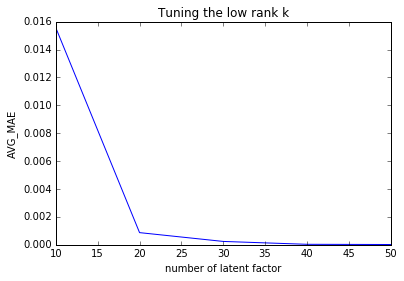

In [30]:
plt.plot(hyper_param, avg_mae)
plt.xlabel('number of latent factor')
plt.ylabel('AVG_MAE')
plt.title('Tuning the low rank k')

plt.show()

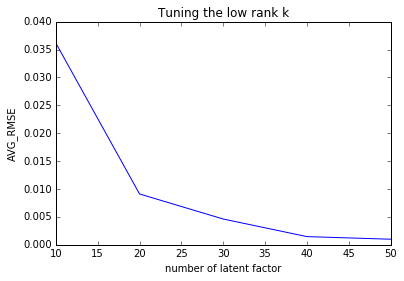

In [31]:
plt.plot(hyper_param, avg_rmse)
plt.xlabel('number of latent factor')
plt.ylabel('AVG_RMSE')
plt.title('Tuning the low rank k')

plt.show()

In [32]:
# use k = 20 latent factors below
def nmf_imputer(df, s, bias = False):
    #NMF input dataframe and s fold
    # output evaluation default setting
    sTime = time.time()
    reader = sp.Reader(rating_scale=(0,1))
    data = sp.Dataset.load_from_df(df[['user','traits','value']], reader)
    data.split(s)
    model = sp.NMF(n_factors=20, n_epochs=30, biased=bias, verbose=False)
    # Evaluate performances of our algorithm on the dataset.
    perf = sp.evaluate(model, data, measures=['RMSE', 'MAE'], n_jobs = -1) #root-mean-square-error, #mean-square-error
    #sp.print_perf(perf)
    print("Running Time: %s sec" % (time.time()-sTime))
    return perf

In [33]:
# 10 fold CV
perf = nmf_imputer(positive_pair_df, 10)

/home/ls3452/anaconda3/lib/python3.5/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/home/ls3452/anaconda3/lib/python3.5/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 0.0084
MAE:  0.0007
------------
Fold 2
RMSE: 0.0088
MAE:  0.0007
------------
Fold 3
RMSE: 0.0059
MAE:  0.0003
------------
Fold 4
RMSE: 0.0068
MAE:  0.0005
------------
Fold 5
RMSE: 0.0073
MAE:  0.0005
------------
Fold 6
RMSE: 0.0047
MAE:  0.0003
------------
Fold 7
RMSE: 0.0073
MAE:  0.0005
------------
Fold 8
RMSE: 0.0105
MAE:  0.0010
------------
Fold 9
RMSE: 0.0109
MAE:  0.0014
------------
Fold 10
RMSE: 0.0052
MAE:  0.0003
------------
------------
Mean RMSE: 0.0076
Mean MAE : 0.0006
------------
------------
Running Time: 541.4391641616821 sec


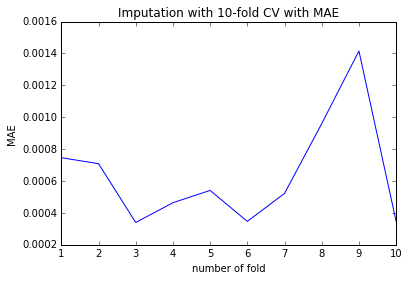

In [37]:
plt.plot(range(1,11), perf["mae"])
plt.xlabel('number of fold')
plt.ylabel('MAE')
plt.title('Imputation with 10-fold CV with MAE')

plt.show()

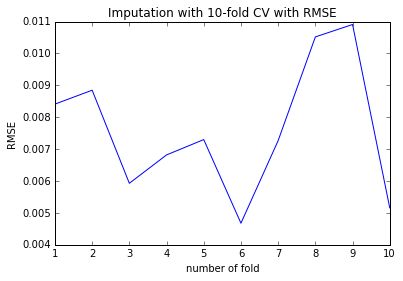

In [38]:
plt.plot(range(1,11), perf["rmse"])
plt.xlabel('number of fold')
plt.ylabel('RMSE')
plt.title('Imputation with 10-fold CV with RMSE')

plt.show()

In [2]:
df = pd.read_csv("sample.csv",index_col='Unnamed: 0').drop_duplicates(subset = 'uuid')
users = df['uuid'].values
traits = [eval(x) for x in df['encodedTraits.indices'].values]
B = nx.DiGraph()
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(list(range(1,5198)), bipartite=1)
for i in range(len(users)):
    for j in range(len(traits[i])):
        B.add_edge(users[i], traits[i][j])
user_traits_matrix = bipartite.matrix.biadjacency_matrix(B, users, list(range(1,5198)))
positive_pair_df = pd.DataFrame(B.edges(), columns = ['user', 'traits'])
positive_pair_df['value'] = 1

/home/ls3452/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
reader = sp.Reader(rating_scale=(0,1))
data = sp.Dataset.load_from_df(positive_pair_df[['user','traits','value']], reader)
model = sp.NMF(n_factors=20, n_epochs=30, verbose=True)
data = data.build_full_trainset()
model.fit(data)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


In [ ]:
f = open("NMF_imputation.txt", "w")
for u in users:
    for i in range(1, 5198):
        prediction = model.predict(u, i)
        if prediction[4]['was_impossible']:
            f.write(prediction[0] + ' ' + str(prediction[1]) + ' ' + str(prediction[3]) + '\n')
        else:
            f.write(prediction[0] + ' ' + str(prediction[1]) + ' ' + str(0) + '\n')

In [ ]:
f.close()

In [78]:
prediction[4]['was_impossible']

False